#  <font color='blue'>Predicting breakout seasons of individual players in the NBA</font>

## Imports

In [2]:
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo, leaguestandings, teaminfocommon
from nba_api.stats.static import players, teams
import pandas as pd
import numpy as np
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Collect data

In [ ]:
# Basically I used the NBA API to collect the data. It takes time, and sometimes limited for the amount of calls.
# But, instead of doing it yourself, you can just upload the already collected & parsed data below (players_data).

In [3]:
# a dataset from the NBA API
active_players = players.get_active_players()

In [ ]:
# Add player name
for player in active_players[371:]:
    player_df = playercareerstats.PlayerCareerStats(player_id = player['id']).get_data_frames()[0]
    player_df['player_name'] = [player['full_name'] for i in range(len(player_df))]
    players_data = pd.concat([players_data, player_df])
players_data.reset_index(drop=True, inplace=True)# a dataset from the NBA API
active_players = players.get_active_players()

### Initial EDA

In [36]:
players_data

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,player_name
0,203500,2013-14,00,1610612760,OKC,20.0,81,20,1197.0,93,...,142,190,332,43,40,57,71,203,265,Steven Adams
1,203500,2014-15,00,1610612760,OKC,21.0,70,67,1771.0,217,...,199,324,523,66,38,86,99,222,537,Steven Adams
2,203500,2015-16,00,1610612760,OKC,22.0,80,80,2014.0,261,...,219,314,533,62,42,89,84,223,636,Steven Adams
3,203500,2016-17,00,1610612760,OKC,23.0,80,80,2389.0,374,...,281,332,613,86,89,78,146,195,905,Steven Adams
4,203500,2017-18,00,1610612760,OKC,24.0,76,76,2487.0,448,...,384,301,685,88,92,78,128,215,1056,Steven Adams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1627826,2018-19,00,0,TOT,22.0,59,37,1039.0,212,...,115,247,362,63,14,51,70,137,525,Ivica Zubac
5,1627826,2019-20,00,1610612746,LAC,23.0,72,70,1326.0,236,...,197,346,543,82,16,66,61,168,596,Ivica Zubac
6,1627826,2020-21,00,1610612746,LAC,24.0,72,33,1609.0,257,...,189,330,519,90,24,62,81,187,650,Ivica Zubac
7,1627826,2021-22,00,1610612746,LAC,25.0,76,76,1852.0,310,...,217,427,644,120,36,77,114,203,785,Ivica Zubac


In [39]:
players_data.columns

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'player_name'],
      dtype='object')

In [41]:
players_data.isna().sum()

PLAYER_ID            0
SEASON_ID            0
LEAGUE_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
PLAYER_AGE           0
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PTS                  0
player_name          0
dtype: int64

In [51]:
for col in players_data.columns:
    if col not in ['TEAM_ABBREVIATION', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'player_name', 'SEASON_ID']:
        players_data[col] = players_data[col].astype(int)

In [53]:
players_data.describe()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
count,4.474000e+03,4474.0,4.474000e+03,4474.000000,4474.00000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,...,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000
mean,7.263766e+05,0.0,1.470575e+09,26.100805,48.06236,26.270228,1198.694904,201.996424,437.693563,0.450774,...,0.729017,51.864327,166.961332,218.825659,117.544032,39.053420,24.512740,69.026151,97.828118,548.845329
std,7.014732e+05,0.0,4.538523e+08,3.874326,24.72170,27.787448,837.926364,172.470451,366.863971,0.095799,...,0.180614,58.015537,143.782269,194.083730,131.677897,33.493853,30.217069,62.558396,66.745642,477.046961
min,1.713000e+03,0.0,0.000000e+00,19.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.019610e+05,0.0,1.610613e+09,23.000000,26.00000,1.000000,444.250000,61.000000,137.000000,0.410000,...,0.680250,13.000000,54.000000,70.000000,28.000000,12.000000,5.000000,21.000000,40.000000,163.000000
50%,2.034960e+05,0.0,1.610613e+09,26.000000,53.00000,14.000000,1117.500000,162.000000,352.000000,0.445000,...,0.769000,32.000000,135.000000,170.000000,75.000000,31.000000,15.000000,53.000000,93.000000,436.000000
75%,1.627827e+06,0.0,1.610613e+09,29.000000,70.00000,51.000000,1876.750000,299.000000,650.750000,0.493000,...,0.833000,67.750000,237.000000,309.750000,154.000000,57.000000,31.750000,99.000000,146.000000,819.750000
max,1.629760e+06,0.0,1.610613e+09,43.000000,82.00000,82.000000,3388.000000,875.000000,1941.000000,1.000000,...,1.000000,440.000000,882.000000,1247.000000,925.000000,217.000000,269.000000,464.000000,332.000000,2818.000000


In [54]:
players_data[players_data.duplicated()].shape[0]

0

Features distributions:



<Figure size 432x288 with 0 Axes>

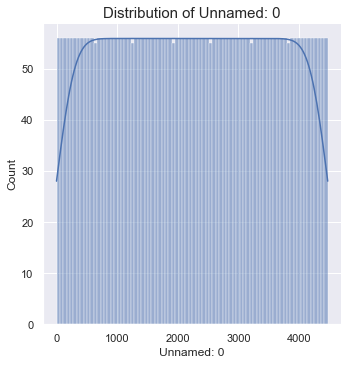


Features distributions:



<Figure size 432x288 with 0 Axes>

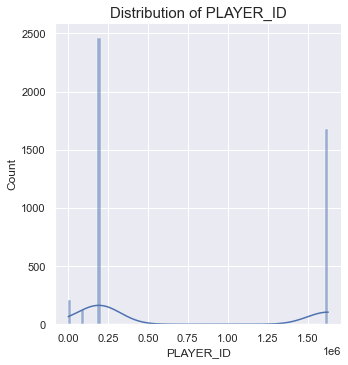


Features distributions:



/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

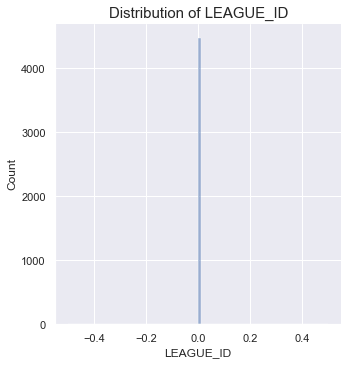


Features distributions:



<Figure size 432x288 with 0 Axes>

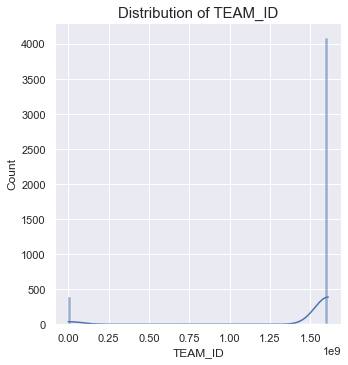


Features distributions:



<Figure size 432x288 with 0 Axes>

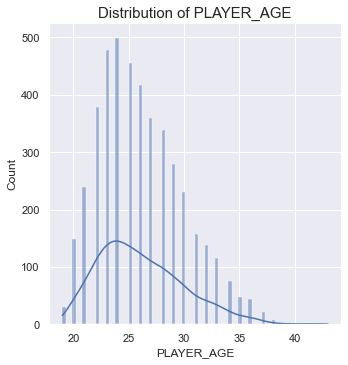


Features distributions:



<Figure size 432x288 with 0 Axes>

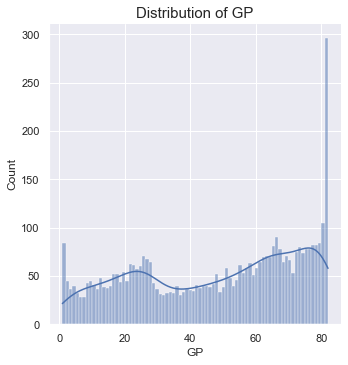


Features distributions:



<Figure size 432x288 with 0 Axes>

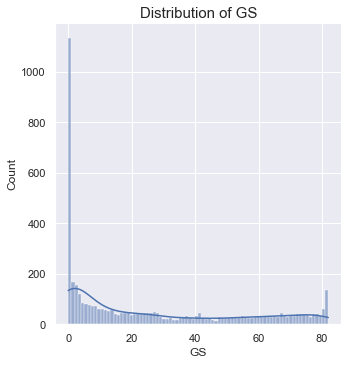


Features distributions:



<Figure size 432x288 with 0 Axes>

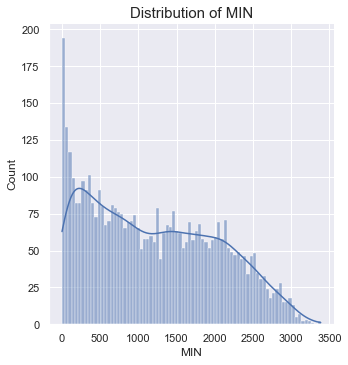


Features distributions:



<Figure size 432x288 with 0 Axes>

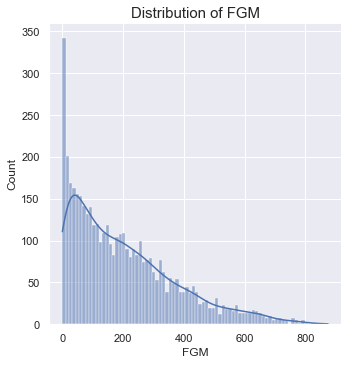


Features distributions:



<Figure size 432x288 with 0 Axes>

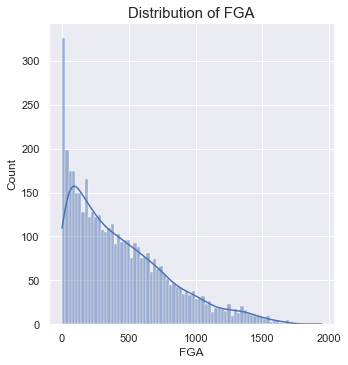


Features distributions:



<Figure size 432x288 with 0 Axes>

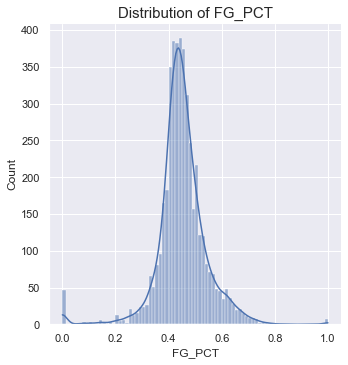


Features distributions:



<Figure size 432x288 with 0 Axes>

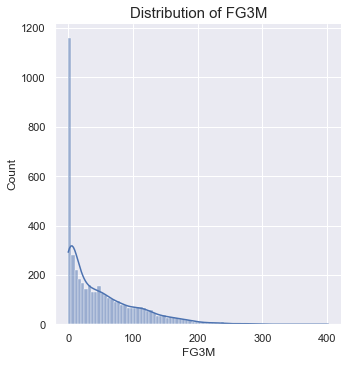


Features distributions:



<Figure size 432x288 with 0 Axes>

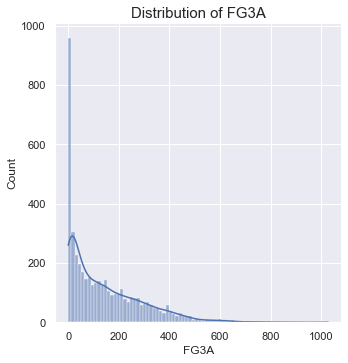


Features distributions:



<Figure size 432x288 with 0 Axes>

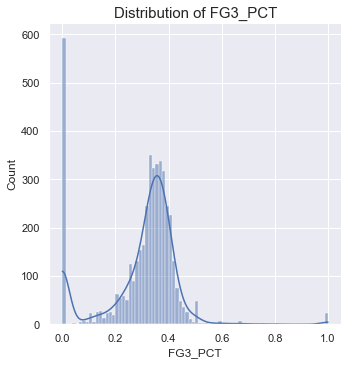


Features distributions:



<Figure size 432x288 with 0 Axes>

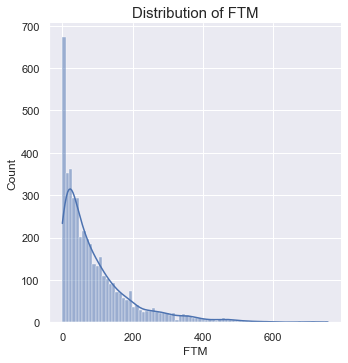


Features distributions:



<Figure size 432x288 with 0 Axes>

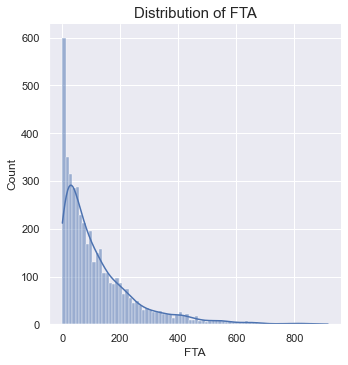


Features distributions:



<Figure size 432x288 with 0 Axes>

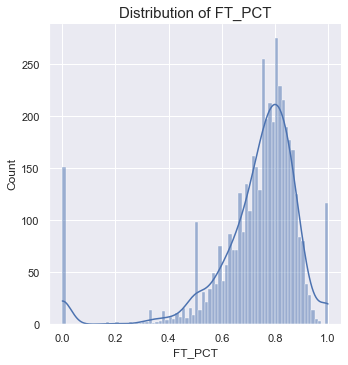


Features distributions:



<Figure size 432x288 with 0 Axes>

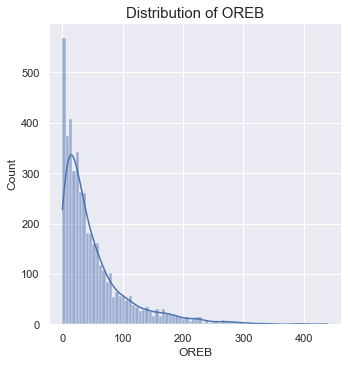


Features distributions:



<Figure size 432x288 with 0 Axes>

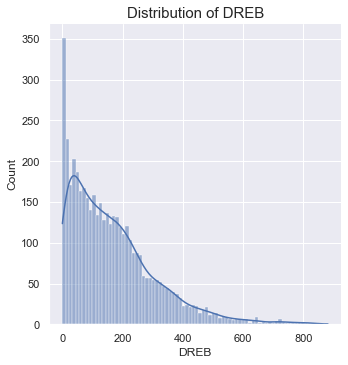


Features distributions:



<Figure size 432x288 with 0 Axes>

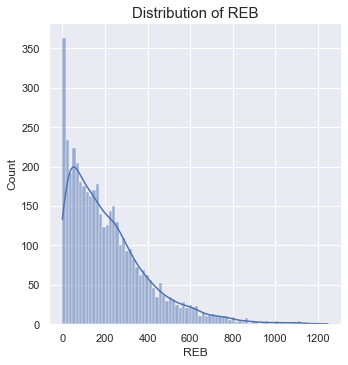


Features distributions:



<Figure size 432x288 with 0 Axes>

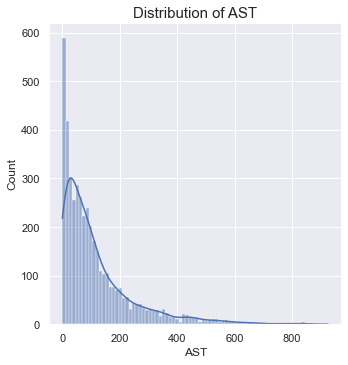


Features distributions:



<Figure size 432x288 with 0 Axes>

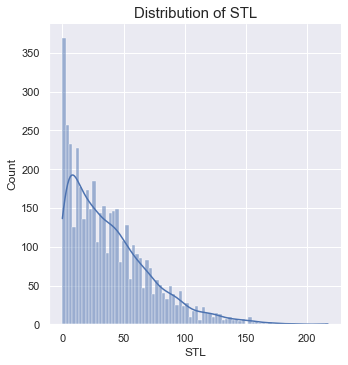


Features distributions:



<Figure size 432x288 with 0 Axes>

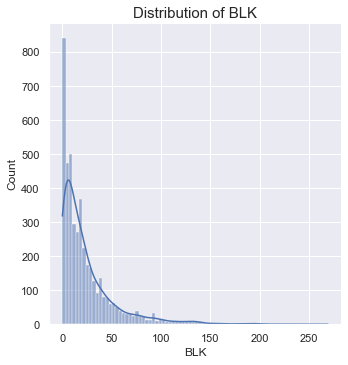


Features distributions:



<Figure size 432x288 with 0 Axes>

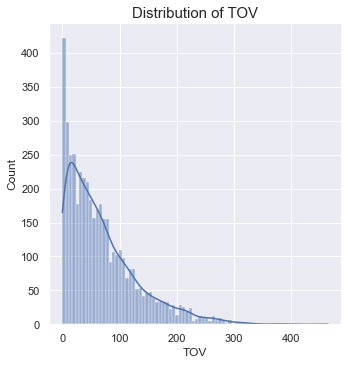


Features distributions:



<Figure size 432x288 with 0 Axes>

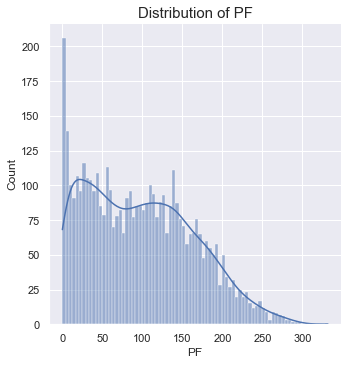


Features distributions:



<Figure size 432x288 with 0 Axes>

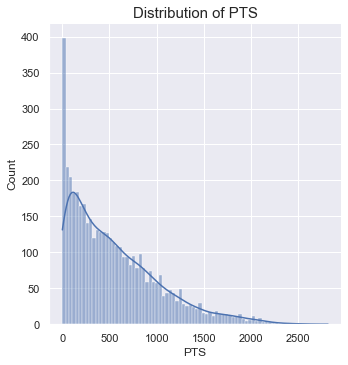


Features distributions:



<Figure size 432x288 with 0 Axes>

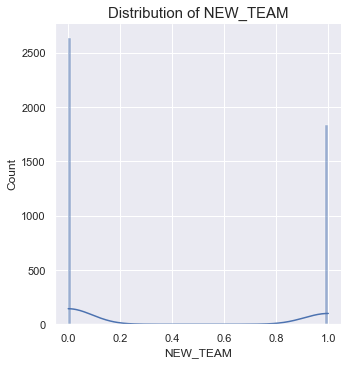


Features distributions:



<Figure size 432x288 with 0 Axes>

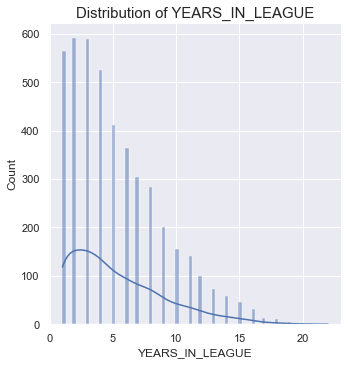


Features distributions:



<Figure size 432x288 with 0 Axes>

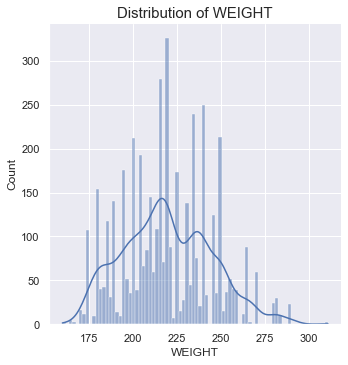


Features distributions:



<Figure size 432x288 with 0 Axes>

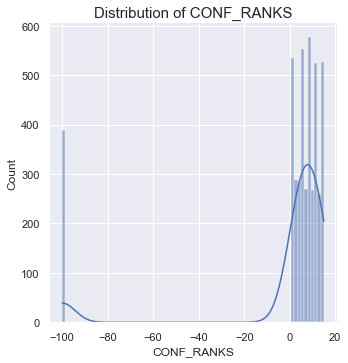


Features distributions:



<Figure size 432x288 with 0 Axes>

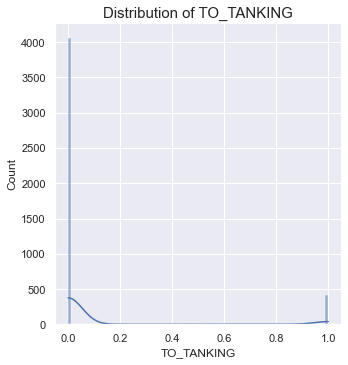


Features distributions:



<Figure size 432x288 with 0 Axes>

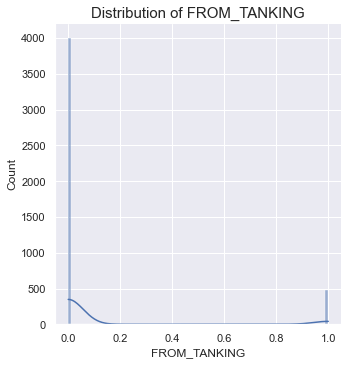


Features distributions:



<Figure size 432x288 with 0 Axes>

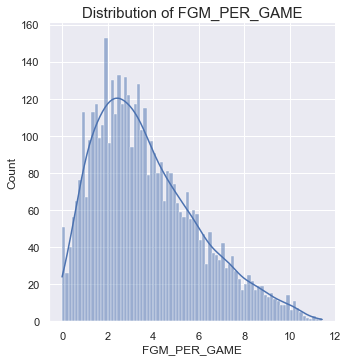


Features distributions:



<Figure size 432x288 with 0 Axes>

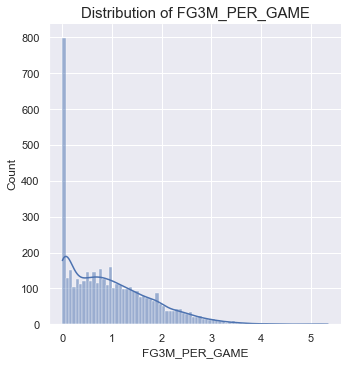


Features distributions:



<Figure size 432x288 with 0 Axes>

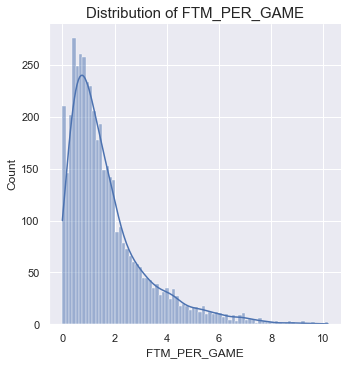


Features distributions:



<Figure size 432x288 with 0 Axes>

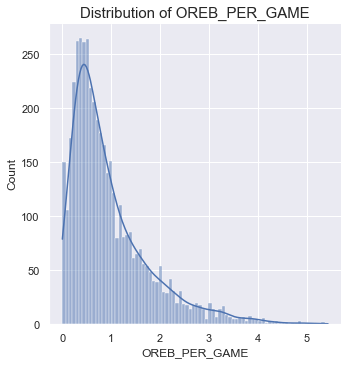


Features distributions:



<Figure size 432x288 with 0 Axes>

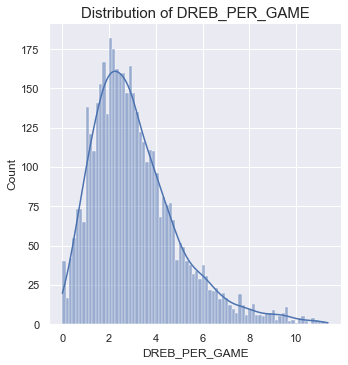


Features distributions:



<Figure size 432x288 with 0 Axes>

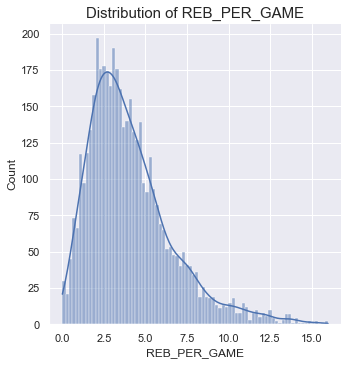


Features distributions:



<Figure size 432x288 with 0 Axes>

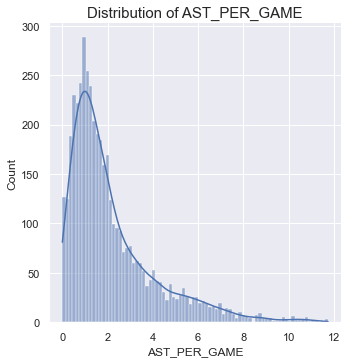


Features distributions:



<Figure size 432x288 with 0 Axes>

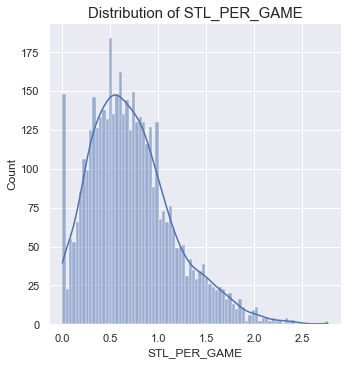


Features distributions:



<Figure size 432x288 with 0 Axes>

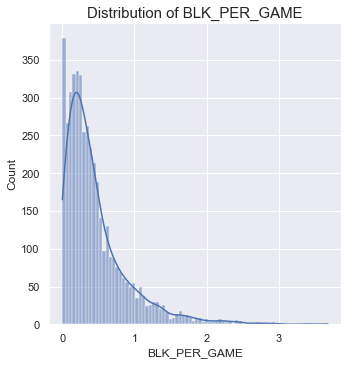


Features distributions:



<Figure size 432x288 with 0 Axes>

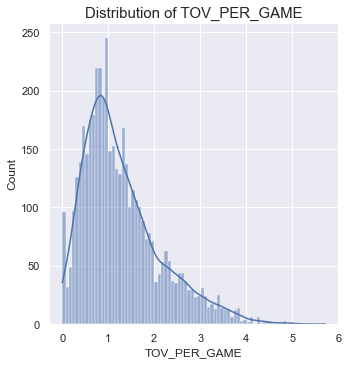


Features distributions:



<Figure size 432x288 with 0 Axes>

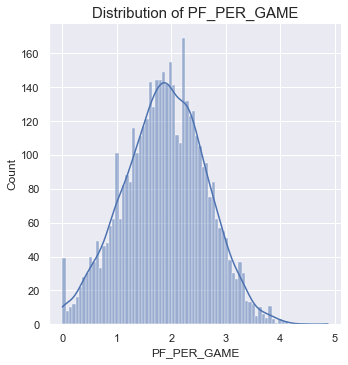


Features distributions:



<Figure size 432x288 with 0 Axes>

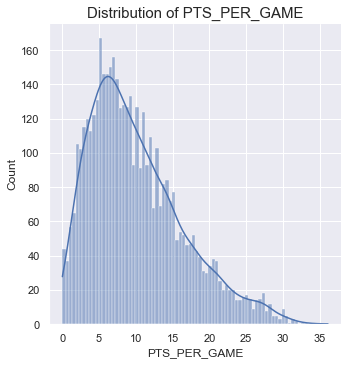


Features distributions:



<Figure size 432x288 with 0 Axes>

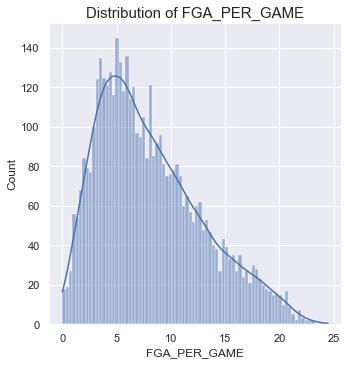


Features distributions:



<Figure size 432x288 with 0 Axes>

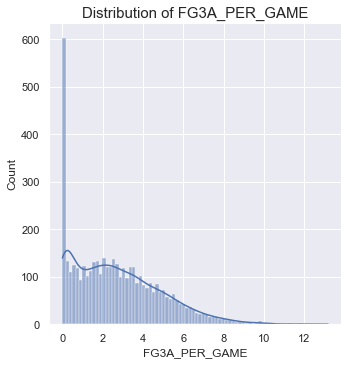


Features distributions:



<Figure size 432x288 with 0 Axes>

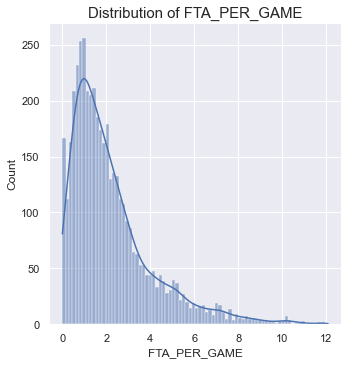


Features distributions:



<Figure size 432x288 with 0 Axes>

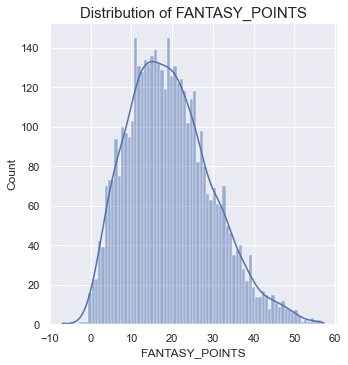


Features distributions:



<Figure size 432x288 with 0 Axes>

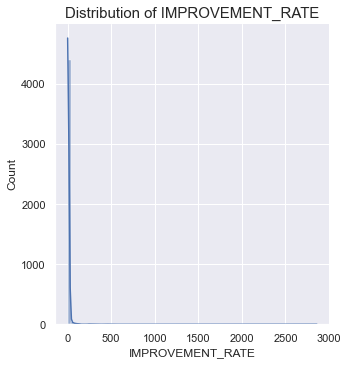


Features distributions:



<Figure size 432x288 with 0 Axes>

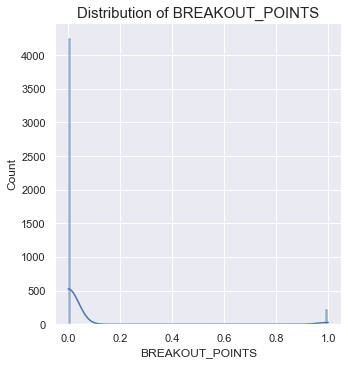

In [1042]:
def plot_distributions(data):
    numeric_feats = data.select_dtypes(include=np.number)
    categorial_feats = data.select_dtypes(exclude=np.number)
    con_feats = []
    disc_feats = []
    for feat in numeric_feats:
     #   if data[feat].nunique()/len(data) > 0.25:
     #       con_feats.append(feat)
     #   else:
     #       disc_feats.append(feat)
    #if len(con_feats) > 0:
        print('Features distributions:')
        print()
        #for c_feat in con_feats:
        plt.figure()
        sns.set(style="darkgrid")
        sns.displot(data, x=feat, bins=80, kde=True)
        plt.title('Distribution of {}'.format(feat), fontsize=15)
        plt.xlabel(feat)
        plt.show()
        print()
            
plot_distributions(players_data)

### Expand data with more features

In [67]:
# Add if a player changed teams or not
new_team = []
for i in range(len(players_data)-1):
    if players_data.loc[i, 'PLAYER_ID'] == players_data.loc[i+1, 'PLAYER_ID'] and players_data.loc[i, 'TEAM_ID'] != players_data.loc[i+1, 'TEAM_ID']:
        new_team.append(1)
    else:
        new_team.append(0)
new_team.append(0)
players_data['NEW_TEAM'] = new_team

In [75]:
# Add no. of years in the league
years_in_league = [1]
year = 1
for i in range(1, len(players_data)):
    if players_data.loc[i, 'PLAYER_ID'] == players_data.loc[i-1, 'PLAYER_ID']:
        if players_data.loc[i, 'SEASON_ID'] != players_data.loc[i-1, 'SEASON_ID']:
            year += 1
            years_in_league.append(year)
        else:
            years_in_league.append(year)
    else:
        year = 1
        years_in_league.append(year)
players_data['YEARS_IN_LEAGUE'] = years_in_league

In [134]:
# Add players personal info
position = []
height = []
weight = []
country = []
draft_round = []
draft_pick = []

for i in range(len(players_ids)):
    p_id = players_ids[i]
    p_info = commonplayerinfo.CommonPlayerInfo(player_id = str(p_id)).get_data_frames()[0]
    position.append(p_info.POSITION.values[0])
    height.append(p_info.HEIGHT.values[0])
    weight.append(p_info.WEIGHT.values[0])
    country.append(p_info.COUNTRY.values[0])
    draft_round.append(p_info.DRAFT_ROUND.values[0])
    draft_pick.append(p_info.DRAFT_NUMBER.values[0])

In [148]:
pers_info_dict = {'ID': players_ids, 'POSITION': position, 'HEIGHT': height, 'WEIGHT': weight, 'COUNTRY': country, 'DRAFT_ROUND': draft_round, 'DRAFT_PICK': draft_pick}
pers_info_df = pd.DataFrame.from_dict(pers_info_dict)

In [152]:
position2 = []
height2 = []
weight2 = []
country2 = []
draft_round2 = []
draft_pick2 = []

for i in range(len(players_data)):
    player_id = players_data.loc[i, 'PLAYER_ID']
    player_inf = pers_info_df[pers_info_df['ID'] == player_id]

    position2.append(player_inf.POSITION.values[0])
    height2.append(player_inf.HEIGHT.values[0])
    weight2.append(player_inf.WEIGHT.values[0])
    country2.append(player_inf.COUNTRY.values[0])
    draft_round2.append(player_inf.DRAFT_ROUND.values[0])
    draft_pick2.append(player_inf.DRAFT_PICK.values[0])
    
players_data['POSITION'] = position2
players_data['HEIGHT'] = height2
players_data['WEIGHT'] = weight2
players_data['COUNTRY'] = country2
players_data['DRAFT_ROUND'] = draft_round2
players_data['DRAFT_PICK'] = draft_pick2

In [210]:
# Add the team conference rankings
team_ids = players_data['TEAM_ID'].unique().tolist()
team_ids.remove(0)
season_ids = []
s_ids = players_data['SEASON_ID'].unique().tolist()
for s_id in s_ids:
    season_ids.append(int(s_id[:4]))

In [256]:
conf_ranks = []
for team_id in team_ids:
    for season_id in season_ids:
        rank_df = teaminfocommon.TeamInfoCommon(team_id=team_id, season_nullable=season_id).get_data_frames()[0]
        try:
            conf_ranks.append(rank_df['CONF_RANK'].values[0])
        except IndexError:
            conf_ranks.append(np.nan)

In [266]:
rank_dict = {'team_id': sum([[x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x] for x in team_ids], []), 'season_id': season_ids * 30, 'conf_ranks': conf_ranks}
rank_df = pd.DataFrame.from_dict(rank_dict)


In [277]:
conf_ranks_full = []
for i in range(len(players_data)):
    team_id = players_data.loc[i, 'TEAM_ID']
    season_id = int(players_data.loc[i, 'SEASON_ID'][:4])
    try:
        rank = int(rank_df[(rank_df['season_id'] == season_id) & (rank_df['team_id'] == team_id)]['conf_ranks'].values[0])
    except IndexError:
        rank = -100
    conf_ranks_full.append(rank)
players_data['CONF_RANKS'] = conf_ranks_full
    

In [288]:
# Add if a player moved from or to a tanking team
tank_spots = [13, 14, 15]
moved_to_tank = []
moved_from_tank = []
for i in range(1, len(players_data)):
    curr_rank = players_data.iloc[i]['CONF_RANKS']
    prev_rank = players_data.iloc[i-1]['CONF_RANKS']
    curr_player = players_data.iloc[i]['PLAYER_ID']
    prev_player = players_data.iloc[i-1]['PLAYER_ID']
    if prev_rank in tank_spots and curr_rank not in tank_spots and curr_player == prev_player:
        moved_from_tank.append(1)
        moved_to_tank.append(0)
    elif prev_rank not in tank_spots and curr_rank in tank_spots and curr_player == prev_player:
        moved_from_tank.append(0)
        moved_to_tank.append(1)
    else:
        moved_from_tank.append(0)
        moved_to_tank.append(0)
players_data['TO_TANKING'] = [0] + moved_to_tank
players_data['FROM_TANKING'] = [0] + moved_from_tank


In [303]:
# Add per game stats
for cat in ['FGM', 'FG3M', 'FTM', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']:
    players_data[cat + '_PER_GAME'] = round(players_data[cat] / players_data['GP'], 3)

## Define and determine a "breakout season"

### Compute fantasy points

In [319]:
points_scores = {'FGM_PER_GAME': 1.0,
 'FG3M_PER_GAME': 3.0,
 'FTM_PER_GAME': 1.0,
 'REB_PER_GAME': 1.5,
 'AST_PER_GAME': 2.0,
 'STL_PER_GAME': 3.0,
 'BLK_PER_GAME': 3.0,
 'TOV_PER_GAME': -2.0,
 'PTS_PER_GAME': 0.5,
 'FGA_PER_GAME': -0.45,
 'FTA_PER_GAME': -0.75}

points = []
for i in range(len(players_data)):
    tot_score = 0
    for col, score in points_scores.items():
        tot_score += players_data.iloc[i][col] * score
    points.append(round(tot_score, 1))
players_data['FANTASY_POINTS'] = points

### Look at the distribution and and consider the  top 5% as breakouts.

In [161]:
diff_points = [0]
for i in range(1, len(players_data)):
    if players_data.iloc[i]['PLAYER_ID'] == players_data.iloc[i-1]['PLAYER_ID']:
        diff_points.append(players_data.iloc[i]['FANTASY_POINTS'] - players_data.iloc[i-1]['FANTASY_POINTS'])
    else:
        diff_points.append(0)

<AxesSubplot:>

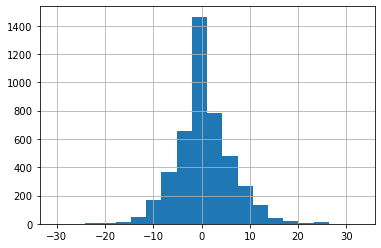

In [164]:
pd.Series(diff_points).hist(bins=20)

In [166]:
np.quantile(np.array(diff_points), .95)

10.5

In [214]:
breakouts = []
for season in list(set(players_data['SEASON_ID'].values)):
    if len(players_data[players_data['SEASON_ID'] == season]) > 2:
        print(season)
        print(players_data[players_data['SEASON_ID'] == season]['BREAKOUT_POINTS'].values.sum())
        breakouts.append(players_data[players_data['SEASON_ID'] == season]['BREAKOUT_POINTS'].values.sum())

2005-06
1
2014-15
15
2008-09
3
2020-21
20
2021-22
13
2004-05
1
2015-16
9
2010-11
5
2018-19
34
2007-08
3
2013-14
11
2022-23
0
2002-03
0
2011-12
6
2016-17
18
2006-07
3
2019-20
32
2009-10
6
2003-04
2
2017-18
26
2012-13
12


In [213]:
# Add the target column
breakout_points = []
for i in range(1, len(players_data)):
    if players_data.iloc[i]['PLAYER_ID'] == players_data.iloc[i-1]['PLAYER_ID']:
        if players_data.iloc[i]['FANTASY_POINTS'] - players_data.iloc[i-1]['FANTASY_POINTS'] > 10.5:
            breakout_points.append(1)
        else:
            breakout_points.append(0)
    else:
        breakout_points.append(0)
breakout_points.append(0)
players_data['BREAKOUT_POINTS'] = breakout_points

In [1045]:
players_data

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,FGA_PER_GAME,FG3A_PER_GAME,FTA_PER_GAME,FANTASY_POINTS,IMPROVEMENT_RATE,BREAKOUT_POINTS
0,203500,2013-14,0,1610612760,OKC,20,81,20,1197,93,...,0.704,0.877,2.506,3.272,2.284,0.000,1.679,10.5,0.000,0
1,203500,2014-15,0,1610612760,OKC,21,70,67,1771,217,...,1.229,1.414,3.171,7.671,5.700,0.029,2.929,19.2,1.545,0
2,203500,2015-16,0,1610612760,OKC,22,80,80,2014,261,...,1.112,1.050,2.788,7.950,5.325,0.000,2.450,18.8,1.122,0
3,203500,2016-17,0,1610612760,OKC,23,80,80,2389,374,...,0.975,1.825,2.438,11.312,8.188,0.012,3.212,22.5,1.426,0
4,203500,2017-18,0,1610612760,OKC,24,76,76,2487,448,...,1.026,1.684,2.829,13.895,9.368,0.026,3.763,27.1,1.089,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4469,1627826,2018-19,0,0,TOT,22,59,37,1039,212,...,0.864,1.186,2.322,8.898,6.424,0.000,2.136,17.5,1.829,0
4470,1627826,2019-20,0,1610612746,LAC,23,72,70,1326,236,...,0.917,0.847,2.333,8.278,5.347,0.028,2.306,20.3,1.275,0
4471,1627826,2020-21,0,1610612746,LAC,24,72,33,1609,257,...,0.861,1.125,2.597,9.028,5.472,0.056,2.375,20.4,2.951,0
4472,1627826,2021-22,0,1610612746,LAC,25,76,76,1852,310,...,1.013,1.500,2.671,10.329,6.513,0.000,2.987,23.6,1.305,0


In [1046]:
# Save data
players_data.to_csv('nba_players_data.csv', index=False)

## Get dataset ready for training

In [4]:
players_data = pd.read_csv('nba_players_data.csv')

In [1055]:
players_data.isna().sum()

PLAYER_ID             0
SEASON_ID             0
LEAGUE_ID             0
TEAM_ID               0
TEAM_ABBREVIATION     0
PLAYER_AGE            0
GP                    0
GS                    0
MIN                   0
FGM                   0
FGA                   0
FG_PCT                0
FG3M                  0
FG3A                  0
FG3_PCT               0
FTM                   0
FTA                   0
FT_PCT                0
OREB                  0
DREB                  0
REB                   0
AST                   0
STL                   0
BLK                   0
TOV                   0
PF                    0
PTS                   0
player_name           0
NEW_TEAM              0
YEARS_IN_LEAGUE       0
POSITION              0
HEIGHT                0
WEIGHT                0
COUNTRY               0
DRAFT_ROUND          15
DRAFT_PICK           23
CONF_RANKS            0
TO_TANKING            0
FROM_TANKING          0
FGM_PER_GAME          0
FG3M_PER_GAME         0
FTM_PER_GAME    

In [6]:
# Fill nulls with -1
players_data['DRAFT_ROUND'].fillna(-1, inplace=True)
players_data['DRAFT_PICK'].fillna(-1, inplace=True)

In [380]:
players_data.describe()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,...,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,FGA_PER_GAME,FG3A_PER_GAME,FTA_PER_GAME,FANTASY_POINTS,IMPROVEMENT_RATE,BREAKOUT_POINTS
count,4.474000e+03,4474.0,4.474000e+03,4474.000000,4474.00000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,...,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000
mean,7.263766e+05,0.0,1.470575e+09,26.100805,48.06236,26.270228,1198.694904,201.996424,437.693563,0.450774,...,0.457302,1.287657,1.877905,10.077081,8.109594,2.717759,2.215830,19.492602,6.094030,0.021234
std,7.014732e+05,0.0,4.538523e+08,3.874326,24.72170,27.787448,837.926364,172.470451,366.863971,0.095799,...,0.449328,0.857661,0.752188,6.395883,4.818197,2.180124,1.890638,10.391929,68.570026,0.144179
min,1.713000e+03,0.0,0.000000e+00,19.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000
25%,2.019610e+05,0.0,1.610613e+09,23.000000,26.00000,1.000000,444.250000,61.000000,137.000000,0.410000,...,0.162000,0.678250,1.371000,5.251000,4.340500,0.871250,0.892000,11.700000,0.702000,0.000000
50%,2.034960e+05,0.0,1.610613e+09,26.000000,53.00000,14.000000,1117.500000,162.000000,352.000000,0.445000,...,0.333000,1.075000,1.896000,8.816500,7.173500,2.414000,1.684000,18.600000,1.079000,0.000000
75%,1.627827e+06,0.0,1.610613e+09,29.000000,70.00000,51.000000,1876.750000,299.000000,650.750000,0.493000,...,0.600000,1.702500,2.400000,13.788250,11.100000,4.108500,2.913000,26.000000,1.759250,0.000000
max,1.629760e+06,0.0,1.610613e+09,43.000000,82.00000,82.000000,3388.000000,875.000000,1941.000000,1.000000,...,3.685000,5.728000,4.875000,36.128000,24.474000,13.179000,12.083000,57.200000,2860.000000,1.000000


In [381]:
# Decide which columns to keep for the training
players_data.columns

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'player_name', 'NEW_TEAM', 'YEARS_IN_LEAGUE',
       'POSITION', 'HEIGHT', 'WEIGHT', 'COUNTRY', 'DRAFT_ROUND', 'DRAFT_PICK',
       'CONF_RANKS', 'TO_TANKING', 'FROM_TANKING', 'FGM_PER_GAME',
       'FG3M_PER_GAME', 'FTM_PER_GAME', 'OREB_PER_GAME', 'DREB_PER_GAME',
       'REB_PER_GAME', 'AST_PER_GAME', 'STL_PER_GAME', 'BLK_PER_GAME',
       'TOV_PER_GAME', 'PF_PER_GAME', 'PTS_PER_GAME', 'FGA_PER_GAME',
       'FG3A_PER_GAME', 'FTA_PER_GAME', 'FANTASY_POINTS', 'IMPROVEMENT_RATE',
       'BREAKOUT_POINTS'],
      dtype='object')

In [7]:
drop_list = ['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ABBREVIATION', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
            'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 
            'player_name', 'FANTASY_POINTS', 'IMPROVEMENT_RATE']
clean_data = players_data.drop(drop_list, axis=1)

In [386]:
clean_data.select_dtypes(include=object)

,POSITION,HEIGHT,WEIGHT,COUNTRY,DRAFT_ROUND,DRAFT_PICK
0,Center,6-11,265,New Zealand,1,12
1,Center,6-11,265,New Zealand,1,12
2,Center,6-11,265,New Zealand,1,12
3,Center,6-11,265,New Zealand,1,12
4,Center,6-11,265,New Zealand,1,12
...,...,...,...,...,...,...
4469,Center,7-0,240,Croatia,2,32
4470,Center,7-0,240,Croatia,2,32
4471,Center,7-0,240,Croatia,2,32
4472,Center,7-0,240,Croatia,2,32


In [8]:
# Change to numeric features
clean_data.DRAFT_ROUND = clean_data.DRAFT_ROUND.replace('Undrafted', -1)
clean_data.DRAFT_PICK = clean_data.DRAFT_PICK.replace('Undrafted', -1)

clean_data.WEIGHT = clean_data.WEIGHT.astype(int)
clean_data.DRAFT_ROUND = clean_data.DRAFT_ROUND.astype(int)
clean_data.DRAFT_PICK = clean_data.DRAFT_PICK.astype(int)

In [9]:
# Encode features
pos_dict = {'Center': 5, 'Center-Forward': 4, 'Forward-Center': 4, 'Forward': 3, 'Forward-Guard': 2, 'Guard-Forward': 2, 'Guard': 1}
for pos, label in pos_dict.items():
    clean_data.POSITION = clean_data.POSITION.replace(pos, label)

In [10]:
cm_vals = []
for inch_val in clean_data.HEIGHT.values:
    height = inch_val.split('-')
    height_cm = round((int(height[0]) * 30.48) + (int(height[1]) * 2.54), 1)
    cm_vals.append(height_cm)
clean_data.HEIGHT = cm_vals

In [11]:
# Change countries to continents
pos_dict = {'DRC': 'Congo'}
for pos, label in pos_dict.items():
    clean_data.COUNTRY = clean_data.COUNTRY.replace(pos, label)

In [15]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

cont_list = []
for i in range(len(clean_data)):
    country = clean_data.iloc[i]['COUNTRY']
    continent = country_to_continent(country)
    cont_list.append(continent)
clean_data['CONTINENT'] = cont_list
clean_data.drop(['COUNTRY'], axis=1, inplace=True)


In [185]:
clean_data['CONTINENT'].value_counts()

North America    3682
Europe            488
Africa            117
Oceania            83
Asia               60
South America      44
Name: CONTINENT, dtype: int64

In [16]:
# Encode continents
pos_dict = {'North America': 1, 'Europe': 2, 'Africa': 3, 'Oceania': 4, 'Asia': 5, 'South America': 6}
for pos, label in pos_dict.items():
    clean_data['CONTINENT'] = clean_data['CONTINENT'].replace(pos, label)

In [21]:
# Save data
clean_data.to_csv('clean_ready_nba_players_data.csv', index=False)

## <font color='red'>Start here with a "ready-to-go" dataset</font>

In [4]:
clean_data = pd.read_csv('clean_ready_nba_players_data.csv')

## Split to train and test, stratifying by target

In [5]:
Y = clean_data['BREAKOUT_POINTS']
X = clean_data.drop(['BREAKOUT_POINTS'], axis=1)
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y =train_test_split(X, Y, stratify=Y, train_size=.8, random_state=0)


In [6]:
# Create scaled datasets by standartization
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X.drop(['TEAM_ID'], axis=1))
test_X_scaled = scaler.transform(test_X.drop(['TEAM_ID'], axis=1))

## Lets start modeling!

### Logistic regression

In [7]:
clf = LogisticRegression(random_state=0).fit(train_X_scaled, train_Y)
pred_Y = clf.predict(test_X_scaled)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.0  Precision:0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Ouch. Perheps changing parameters will help?
clf = LogisticRegression(solver='liblinear', C=10, dual=True, random_state=0).fit(train_X_scaled, train_Y)
Y_pred = clf.predict(test_X_scaled)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.0  Precision:0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision tree

In [9]:
clf = DecisionTreeClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.114  Precision:0.098


In [10]:
# Will feature selection improve the result?:
model = SelectFromModel(clf, prefit=True)
train_X = model.transform(train_X)
test_X = model.transform(test_X)
clf = DecisionTreeClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.136  Precision:0.1


In [11]:
# Go back to the original features:
train_X, test_X, train_Y, test_Y =train_test_split(X, Y, stratify=Y, train_size=.8, random_state=0)

In [12]:
clf = DecisionTreeClassifier(max_depth=4, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.727  Precision:0.081


In [13]:
from sklearn.metrics import f1_score
round(f1_score(test_Y, pred_Y), 3)

0.145

In [14]:
# Do grid search for the decision tree

In [15]:
# optimize recall
dtc = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':(2, 3, 4, 5), 'max_features':[8, 10, 12, 14], 'splitter':['random', 'best'], 'class_weight':['balanced', None]}
clf = GridSearchCV(dtc, parameters, scoring='recall')
clf.fit(train_X, train_Y)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': (2, 3, 4, 5),
                         'max_features': [8, 10, 12, 14],
                         'splitter': ['random', 'best']},
             scoring='recall')

In [16]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 2,
 'max_features': 14,
 'splitter': 'random'}

In [17]:
clf = DecisionTreeClassifier(max_depth=2, max_features=14, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.773  Precision:0.061


In [18]:
# optimize f1-score
dtc = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':(2, 3, 4, 5), 'max_features':[8, 10, 12, 14], 'splitter':['random', 'best'], 'class_weight':['balanced', None]}
clf = GridSearchCV(dtc, parameters, scoring='f1')
clf.fit(train_X, train_Y)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': (2, 3, 4, 5),
                         'max_features': [8, 10, 12, 14],
                         'splitter': ['random', 'best']},
             scoring='f1')

In [19]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 2,
 'max_features': 12,
 'splitter': 'random'}

In [20]:
clf = DecisionTreeClassifier(max_depth=2, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.341  Precision:0.127


In [21]:
round(f1_score(test_Y, pred_Y), 3)

0.185

In [22]:
# optimize precision
dtc = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':(2, 3, 4, 5), 'max_features':[8, 10, 12, 14], 'splitter':['random', 'best'], 'class_weight':['balanced', None]}
clf = GridSearchCV(dtc, parameters, scoring='precision')
clf.fit(train_X, train_Y)
clf.best_params_


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

{'class_weight': None, 'max_depth': 4, 'max_features': 10, 'splitter': 'best'}

In [23]:
clf = DecisionTreeClassifier(max_depth=4, max_features=10, class_weight=None, splitter='best', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.023  Precision:0.167


### Random forest

In [24]:
# No hyperparameter tuning
clf = RandomForestClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.0  Precision:0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# With feature selection:
model = SelectFromModel(clf, prefit=True)
train_X = model.transform(train_X)
test_X = model.transform(test_X)
clf = DecisionTreeClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.136  Precision:0.092


In [26]:
# With some manual hyperparameter tuning
clf = RandomForestClassifier(n_estimators=30, max_depth=2, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.614  Precision:0.092


In [27]:
round(f1_score(test_Y, pred_Y), 3)

0.161

In [28]:
# With feature selection:
model = SelectFromModel(clf, prefit=True)
train_X = model.transform(train_X)
test_X = model.transform(test_X)
clf = DecisionTreeClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.045  Precision:0.038


In [29]:
# Go back to the original features:
train_X, test_X, train_Y, test_Y =train_test_split(X, Y, stratify=Y, train_size=.8, random_state=0)

In [30]:
# Do grid search for the random forest

In [31]:
# Optimizing recall
rfc = RandomForestClassifier(random_state=0)
parameters = {'n_estimators':[10, 20, 30, 40, 50, 100], 'max_depth':(2, 3, 4, 5), 'max_features':[2, 3, 4, 6, 8, 10], 'class_weight':['balanced', None]}
clf = GridSearchCV(rfc, parameters, scoring='recall')
clf.fit(train_X, train_Y)
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 2,
 'max_features': 4,
 'n_estimators': 10}

In [60]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, class_weight='balanced', max_features=4, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.682  Precision:0.1


In [34]:
# Optimizing f1-score
rfc = RandomForestClassifier(random_state=0)
parameters = {'n_estimators':[10, 20, 30, 40, 50, 100], 'max_depth':(2, 3, 4, 5), 'max_features':[2, 3, 4, 6, 8, 10], 'class_weight':['balanced', None]}
clf = GridSearchCV(rfc, parameters, scoring='f1')
clf.fit(train_X, train_Y)
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'max_features': 3,
 'n_estimators': 100}

In [35]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.477  Precision:0.112


In [36]:
round(f1_score(test_Y, pred_Y), 3)

0.181

In [37]:
# Optimizing precision
rfc = RandomForestClassifier(random_state=0)
parameters = {'n_estimators':[10, 20, 30, 40, 50, 100], 'max_depth':(2, 3, 4, 5), 'max_features':[2, 3, 4, 6, 8, 10], 'class_weight':['balanced', None]}
clf = GridSearchCV(rfc, parameters, scoring='precision')
clf.fit(train_X, train_Y)
clf.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision 

{'class_weight': None, 'max_depth': 5, 'max_features': 8, 'n_estimators': 10}

In [61]:
clf = RandomForestClassifier(n_estimators=6, max_depth=15, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.023  Precision:0.333


In [39]:
round(f1_score(test_Y, pred_Y), 3)

0.043

In [40]:
from sklearn.metrics import f1_score
f1_score(test_Y, pred_Y)

0.04255319148936171

### AdaBoost

In [41]:
clf = AdaBoostClassifier(random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.023  Precision:0.1


In [42]:
clf = AdaBoostClassifier(n_estimators=20, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.023  Precision:1.0


In [43]:
clf = AdaBoostClassifier(n_estimators=20, learning_rate=2, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.636  Precision:0.04


### XGBoost

In [44]:
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X, label=test_Y)
param = {'max_depth': 4, 'eval_metric': ['logloss'], 'objective': 'binary:logistic'}
evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	train-logloss:0.48129	eval-logloss:0.48645
[1]	train-logloss:0.36494	eval-logloss:0.37384
[2]	train-logloss:0.29284	eval-logloss:0.30479
[3]	train-logloss:0.24634	eval-logloss:0.26231
[4]	train-logloss:0.21439	eval-logloss:0.23413
[5]	train-logloss:0.19220	eval-logloss:0.21658
[6]	train-logloss:0.17677	eval-logloss:0.20316
[7]	train-logloss:0.16523	eval-logloss:0.19487
[8]	train-logloss:0.15617	eval-logloss:0.18967
[9]	train-logloss:0.14860	eval-logloss:0.18672


In [45]:
bst.save_model('R61P13.model')

In [46]:
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X, label=test_Y)
param = {'max_depth': 4, 'eval_metric': ['logloss'], 'objective': 'binary:logistic'}
evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 12
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.48129	eval-logloss:0.48645
[1]	train-logloss:0.36494	eval-logloss:0.37384
[2]	train-logloss:0.29284	eval-logloss:0.30479
[3]	train-logloss:0.24634	eval-logloss:0.26231
[4]	train-logloss:0.21439	eval-logloss:0.23413
[5]	train-logloss:0.19220	eval-logloss:0.21658
[6]	train-logloss:0.17677	eval-logloss:0.20316
[7]	train-logloss:0.16523	eval-logloss:0.19487
[8]	train-logloss:0.15617	eval-logloss:0.18967
[9]	train-logloss:0.14860	eval-logloss:0.18672
[10]	train-logloss:0.14296	eval-logloss:0.18487
[11]	train-logloss:0.13949	eval-logloss:0.18423


In [47]:
pred_Y = bst.predict(dtest)
pred_Y = (pred_Y > 0.075).astype(int)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.705  Precision:0.133


In [48]:
round(f1_score(test_Y, pred_Y), 3)

0.224

### Voting ensemble that combines the strongest models found

In [49]:
#  hard voting:
clf1 = DecisionTreeClassifier(max_depth=2, max_features=12, class_weight='balanced', splitter='random', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=4, max_features=12, class_weight='balanced', splitter='random', random_state=0)
clf3 = RandomForestClassifier(n_estimators=6, max_depth=15, random_state=0)
clf4 = RandomForestClassifier(n_estimators=30, max_depth=2, class_weight='balanced', max_features=3, random_state=0)
clf5 = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', max_features=3, random_state=0)

eclf = VotingClassifier(estimators=[('dt1', clf1), ('dt2', clf2), ('rf1', clf3), ('rf2', clf4), ('rf3', clf5)], voting='hard')
eclf = eclf.fit(train_X, train_Y)

pred_Y = eclf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.545  Precision:0.134


In [50]:
# soft voting:
eclf = VotingClassifier(estimators=[('dt1', clf1), ('dt2', clf2), ('rf1', clf3), ('rf2', clf4), ('rf3', clf5)], voting='soft')
eclf = eclf.fit(train_X, train_Y)

pred_Y = eclf.predict(test_X)
print(f'Recall: {round(recall_score(test_Y, pred_Y), 3)}  Precision:{round(precision_score(test_Y.values, pred_Y), 3)}')


Recall: 0.386  Precision:0.14


In [51]:
# That actually does not improve our results. Lets compare the results of our top models:

In [52]:
res_dict = {'Model': ['Decision_Tree_1', 'Decision_Tree_2', 'Random_Forest_1', 'Random_Forest_2', 'Random_Forest_3', 'XGBoost_1'], 'Recall': [0.341, 0.727, 0.023, 0.636, 0.477, 0.705], 'Precision': [0.127, 0.081, 0.333, 0.103, 0.112, 0.133], 'F1': [0.185, 0.145, 0.043, 0.177, 0.181, 0.224]}
res_df = pd.DataFrame.from_dict(res_dict)
res_df

,Model,Recall,Precision,F1
0,Decision_Tree_1,0.341,0.127,0.185
1,Decision_Tree_2,0.727,0.081,0.145
2,Random_Forest_1,0.023,0.333,0.043
3,Random_Forest_2,0.636,0.103,0.177
4,Random_Forest_3,0.477,0.112,0.181
5,XGBoost_1,0.705,0.133,0.224


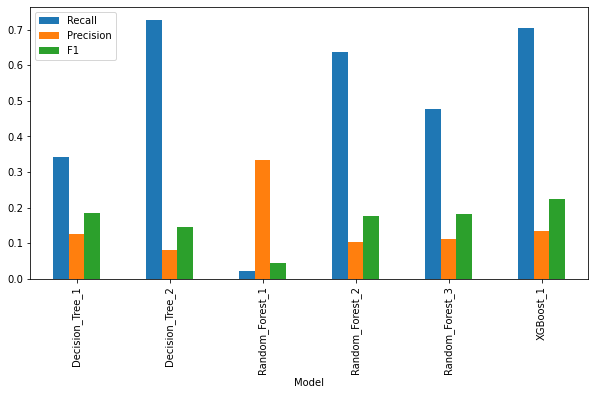

In [53]:
res_df.plot.bar(x='Model', figsize=(10, 5))
plt.show()

In [54]:
# Plot ROC curve:

[0]	train-logloss:0.48129	eval-logloss:0.48645
[1]	train-logloss:0.36494	eval-logloss:0.37384
[2]	train-logloss:0.29284	eval-logloss:0.30479
[3]	train-logloss:0.24634	eval-logloss:0.26231
[4]	train-logloss:0.21439	eval-logloss:0.23413
[5]	train-logloss:0.19220	eval-logloss:0.21658
[6]	train-logloss:0.17677	eval-logloss:0.20316
[7]	train-logloss:0.16523	eval-logloss:0.19487
[8]	train-logloss:0.15617	eval-logloss:0.18967
[9]	train-logloss:0.14860	eval-logloss:0.18672
[10]	train-logloss:0.14296	eval-logloss:0.18487
[11]	train-logloss:0.13949	eval-logloss:0.18423


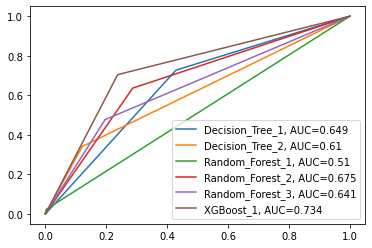

In [55]:
plt.figure(0).clf()

clf = DecisionTreeClassifier(max_depth=4, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="Decision_Tree_1, AUC="+str(auc))


clf = DecisionTreeClassifier(max_depth=2, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="Decision_Tree_2, AUC="+str(auc))

clf = RandomForestClassifier(n_estimators=6, max_depth=15, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="Random_Forest_1, AUC="+str(auc))

clf = RandomForestClassifier(n_estimators=30, max_depth=2, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="Random_Forest_2, AUC="+str(auc))

clf = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="Random_Forest_3, AUC="+str(auc))

dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X, label=test_Y)
param = {'max_depth': 4, 'eval_metric': ['logloss'], 'objective': 'binary:logistic'}
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 12
bst = xgb.train(param, dtrain, num_round, evallist)
pred_Y = bst.predict(dtest)
pred_Y = (pred_Y > 0.075).astype(int)
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
auc = round(roc_auc_score(test_Y, pred_Y), 3)
plt.plot(fpr,tpr,label="XGBoost_1, AUC="+str(auc))

plt.legend()
plt.show()

## Feature importances of the top models

In [56]:
feat_ranks = {'Features': train_X.columns}
clf = DecisionTreeClassifier(max_depth=4, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
feat_ranks['Decision_Tree_1'] = clf.feature_importances_

clf = DecisionTreeClassifier(max_depth=2, max_features=12, class_weight='balanced', splitter='random', random_state=0).fit(train_X, train_Y)
feat_ranks['Decision_Tree_2'] = clf.feature_importances_

clf = RandomForestClassifier(n_estimators=6, max_depth=15, random_state=0).fit(train_X, train_Y)
feat_ranks['Random_forest_1'] = clf.feature_importances_

clf = RandomForestClassifier(n_estimators=30, max_depth=2, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
feat_ranks['Random_forest_2'] = clf.feature_importances_

clf = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', max_features=3, random_state=0).fit(train_X, train_Y)
feat_ranks['Random_forest_3'] = clf.feature_importances_

feat_ranks_df = pd.DataFrame.from_dict(feat_ranks)
feat_ranks_df['Mean'] = feat_ranks_df.mean(axis=1)
feat_ranks_df


,Features,Decision_Tree_1,Decision_Tree_2,Random_forest_1,Random_forest_2,Random_forest_3,Mean
0,TEAM_ID,0.000000,0.000000,0.002832,0.000000,0.002547,0.001076
1,PLAYER_AGE,0.116920,0.000000,0.041501,0.015319,0.050999,0.044948
2,GP,0.000000,0.000000,0.047275,0.006543,0.026613,0.016086
3,GS,0.000000,0.000000,0.028156,0.035288,0.057663,0.024221
4,MIN,0.028491,0.000000,0.052639,0.016379,0.053953,0.030292
5,NEW_TEAM,0.000000,0.000000,0.013815,0.000000,0.003930,0.003549
6,YEARS_IN_LEAGUE,0.000000,0.000000,0.029574,0.057130,0.041658,0.025672
7,POSITION,0.000000,0.000000,0.011677,0.000000,0.005479,0.003431
8,HEIGHT,0.000000,0.000000,0.023011,0.000000,0.008593,0.006321
9,WEIGHT,0.000000,0.000000,0.034562,0.000000,0.015525,0.010018


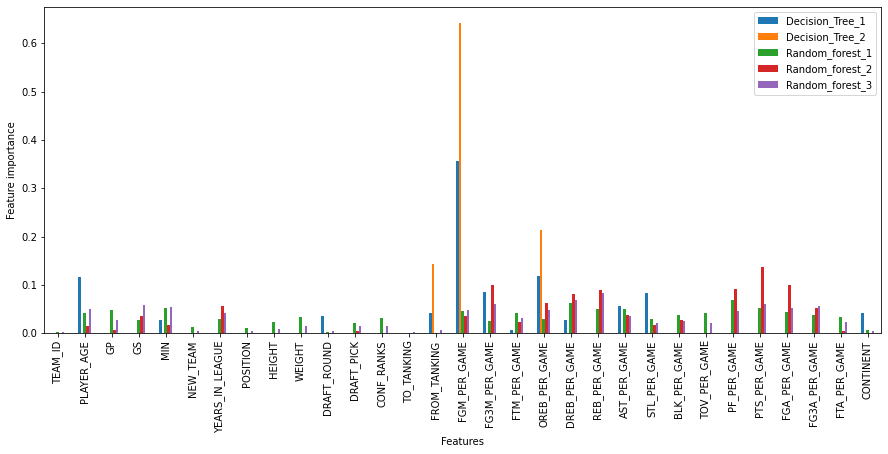

In [57]:
feat_ranks_df.drop(['Mean'], axis=1).set_index('Features').plot.bar(figsize=(15, 6))
plt.ylabel('Feature importance')
plt.show()

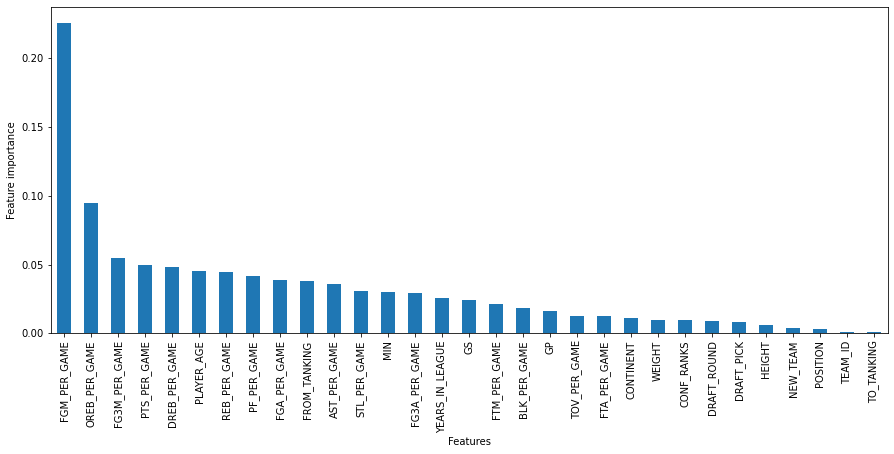

In [58]:
feat_ranks_df[['Features', 'Mean']].set_index('Features').sort_values('Mean', ascending=False).plot.bar(figsize=(15, 6))
plt.legend().remove()
plt.ylabel('Feature importance')
plt.show()

In [59]:
# TO DO:
## Create README file for the GitHub repo
## Write Medium article
## Publish on Linkedin